# Coursera Capstone Project Final Assignment

## Alejandro González Casal 05/03/2021

## 1 - Prepare the enviroment installation and import

### 1.1 - Install the BeautifulSoup and Geopy libraries

In [94]:
!pip install bs4

In [95]:
!pip install geopy

### 1.2 - Import libraries

In [96]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import math
from geopy.geocoders import Nominatim
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


## 2 - Import and preapration of datasets

### 2.1 - Download the first web, saving text response and parsing with BeautifulSoup

In [97]:
html_data = requests.get('https://es.wikipedia.org/wiki/Anexo:Provincias_de_Espa%C3%B1a_por_PIB')
html_data_text = html_data.text

In [98]:
soup = BeautifulSoup(html_data_text, 'html.parser')

In [99]:
#soup.prettify()

### 2.2 - Extract the table row by row using BeautifulSoup

* Firstly, the canada_data dataframe is created with the required columns.
* Then, a loop iterates through the table's rows, the first row with the headers is avoided because it has a different tag (th) and doesn't return anything in: col = row.find_all("td")
* The data of each column is saved in different variables and then appended into the dataframe.
* After appending the line breaking token are deleted.

In [100]:
#soup.find_all("tbody")[0].find_all("tr")

In [101]:
spain_data_1 = pd.DataFrame(columns=["Province", "Autonomous community", "GDP (thousands €)", "GDP/capita (€)"])

for row in soup.find_all("tbody")[1].find_all("tr"):
    col = row.find_all("td")
    if len(col) != 0:
        province = col[1].text.replace("\n","")
        CA = col[2].text.replace("\n","").replace("€","")
        GDP = col[3].text.replace("\n","").replace(".","")
        GDPpc = col[4].text.replace("\n","").replace(".","")
        spain_data_1 = spain_data_1.append({"Province":province, "Autonomous community":CA, "GDP (thousands €)": GDP, "GDP/capita (€)":GDPpc}, ignore_index=True)

spain_data_1 = spain_data_1.drop(0,axis=0)
spain_data_1.at[7,'Province'] = 'Baleares' #to make it match with the one in the second dataset
spain_data_1.head()

,Province,Autonomous community,GDP (thousands €),GDP/capita (€)
1,Madrid,Madrid,231133592,35913
2,Barcelona,Cataluña,171350447,30947
3,Valencia,Comunidad Valenciana,59123107,23363
4,Sevilla,Andalucía,39535345,20314
5,Alicante,Comunidad Valenciana,36521398,19757


### 2.3 - Repeat 2.1+2.2 to the second web

In [102]:
html_data = requests.get('https://es.wikipedia.org/wiki/Anexo:Provincias_y_ciudades_aut%C3%B3nomas_de_Espa%C3%B1a')
html_data_text = html_data.text
html_data.headers
soup = BeautifulSoup(html_data_text, 'html.parser')

In [103]:
#soup.find_all("tbody")[0].find_all("tr")

In [104]:
spain_data_2 = pd.DataFrame(columns=["Province", "Population", "Area(km2)"])

for row in soup.find_all("tbody")[0].find_all("tr"):
    col = row.find_all("td")
    if len(col) != 0:
        province = col[2].text.replace("\n","")
        pob = col[3].text.replace("\n","").replace("\xa0","")
        sup = col[6].text.replace("\n","").replace("&0","").replace("&","").split(".")[0]
        spain_data_2 = spain_data_2.append({"Province":province, "Population": pob, "Area(km2)":sup}, ignore_index=True)
spain_data_2.head()

,Province,Population,Area(km2)
0,Madrid,6779888,8027
1,Barcelona,5743402,7733
2,Valencia,2591875,10807
3,Sevilla,1950219,14036
4,Alicante,1879888,5817


### 2.4 - Merge both datasets using the province name

In [105]:
spain_data = pd.merge(spain_data_1, spain_data_2, on='Province')
spain_data.head()

,Province,Autonomous community,GDP (thousands €),GDP/capita (€),Population,Area(km2)
0,Madrid,Madrid,231133592,35913,6779888,8027
1,Barcelona,Cataluña,171350447,30947,5743402,7733
2,Valencia,Comunidad Valenciana,59123107,23363,2591875,10807
3,Sevilla,Andalucía,39535345,20314,1950219,14036
4,Alicante,Comunidad Valenciana,36521398,19757,1879888,5817


### 2.5 - Extract geographical coordinates and inserting them into the dataset

In [106]:
#get the latitude and longitude coordinates of each spanish province.
for i in spain_data.index:
    prov = spain_data.loc[i,'Province']
    print(f'{prov},', end='')
    address = f'{prov}, ES'
    geolocator = Nominatim(user_agent="es_explorer")
    location = geolocator.geocode(address)
    spain_data.at[i,'Latitude'] = location.latitude
    spain_data.at[i,'Longitude'] = location.longitude
    #print('The geograpical coordinate of {} are {}, {}.'.format(prov,spain_data.at[i,'Latitude'], spain_data.at[i,'Longitude']))
spain_data.head()

Madrid,Barcelona,Valencia,Sevilla,Alicante,Vizcaya,Baleares,Murcia,Málaga,La Coruña,Zaragoza,Tarragona,Guipúzcoa,Las Palmas,Asturias,Santa Cruz de Tenerife,Cádiz,Gerona,Pontevedra,Navarra,Granada,Castellón,Almería,Córdoba,Valladolid,Cantabria,Lérida,Toledo,Álava,Badajoz,Jaén,Ciudad Real,Huelva,Burgos,León,La Rioja,Albacete,Lugo,Cáceres,Salamanca,Orense,Huesca,Guadalajara,Cuenca,Palencia,Zamora,Segovia,Teruel,Ávila,Soria,Ceuta,Melilla,

,Province,Autonomous community,GDP (thousands €),GDP/capita (€),Population,Area(km2),Latitude,Longitude
0,Madrid,Madrid,231133592,35913,6779888,8027,40.416705,-3.703582
1,Barcelona,Cataluña,171350447,30947,5743402,7733,41.382894,2.177432
2,Valencia,Comunidad Valenciana,59123107,23363,2591875,10807,39.469707,-0.376335
3,Sevilla,Andalucía,39535345,20314,1950219,14036,37.388630,-5.995340
4,Alicante,Comunidad Valenciana,36521398,19757,1879888,5817,38.353738,-0.490185


#### Detecting some missing values in the area colunm and replacing them with the actual values.

In [107]:
# In the area column there are missing values ('TBD')
spain_data[spain_data['Area(km2)'] == 'TBD']

,Province,Autonomous community,GDP (thousands €),GDP/capita (€),Population,Area(km2),Latitude,Longitude
11,Tarragona,Cataluña,24567640,30810,804664,TBD,41.117236,1.254606
17,Gerona,Cataluña,21208782,28184,761947,TBD,41.979301,2.819944


In [108]:
#In that case, as it is easy to find information we can google it and complete the dataset.
spain_data.loc[11,'Area(km2)'] = 6303
spain_data.loc[17,'Area(km2)'] = 5905

### 2.6 - Change numerical values datatype from object to float.

In [109]:
spain_data [['GDP (thousands €)','GDP/capita (€)','Population','Area(km2)']] = spain_data[['GDP (thousands €)','GDP/capita (€)','Population','Area(km2)']].astype(float)
spain_data.dtypes

Province                 object
Autonomous community     object
GDP (thousands €)       float64
GDP/capita (€)          float64
Population              float64
Area(km2)               float64
Latitude                float64
Longitude               float64
dtype: object

### 2.7 - Calculate province equivalent radius 

In order to use the radius search provided by Foursquare is needed some aproximation of whether a venue (in this case industrail states or power plants) is within a province. To do so, we will aproximate this radius assuming the provinces as circles (which is quite accurate in the case of Spain).

In [110]:
spain_data['Equivalent radius'] = spain_data['Area(km2)']/math.pi
spain_data['Equivalent radius'] = spain_data['Equivalent radius'].apply(np.sqrt)
spain_data.head()

,Province,Autonomous community,GDP (thousands €),GDP/capita (€),Population,Area(km2),Latitude,Longitude,Equivalent radius
0,Madrid,Madrid,231133592.0,35913.0,6779888.0,8027.0,40.416705,-3.703582,50.547734
1,Barcelona,Cataluña,171350447.0,30947.0,5743402.0,7733.0,41.382894,2.177432,49.613409
2,Valencia,Comunidad Valenciana,59123107.0,23363.0,2591875.0,10807.0,39.469707,-0.376335,58.651300
3,Sevilla,Andalucía,39535345.0,20314.0,1950219.0,14036.0,37.388630,-5.995340,66.841586
4,Alicante,Comunidad Valenciana,36521398.0,19757.0,1879888.0,5817.0,38.353738,-0.490185,43.030322


## 3 - Use Foursquare to extract industrial states and powerplants within a province

### 3.1 Declare FourSquare credentials

In [111]:
CLIENT_ID = 'RDDJKPLXN3F2Z3LVPMIIHN044HZAANGR0IU20Z3IQMRIDQBN' # your Foursquare ID
CLIENT_SECRET = 'Z5UKFZCR5LCCGNBFT5YII22T3IEN0FX1WKTRJNJ0P1COKBY2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RDDJKPLXN3F2Z3LVPMIIHN044HZAANGR0IU20Z3IQMRIDQBN
CLIENT_SECRET:Z5UKFZCR5LCCGNBFT5YII22T3IEN0FX1WKTRJNJ0P1COKBY2


### 3.2 Function to iteratively extract the venues of a given type within the equivalent radius of a province.

In [112]:
def getNearbyVenues(names, latitudes, longitudes, radius, category):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        print(name, lat, lng, rad)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT,
            category)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Province', 
                  'Province Latitude', 
                  'Province Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### 3.2 - Extract Industrial States

As Foursquare only allows the search within a given radius, we will use the equivalent radius of the province (that has been obteined previously by the area of each of them). Firstly we will extract the Industrial states within the provinces using the categoryId = '56aa371be4b08b9a8d5734d7'.

In [113]:
LIMIT = 100
spain_industrial_states = getNearbyVenues(names=spain_data['Province'],
                                   latitudes=spain_data['Latitude'],
                                   longitudes=spain_data['Longitude'],
                                   radius=spain_data['Equivalent radius']*1000,
                                   category = '56aa371be4b08b9a8d5734d7'
                                  )

Madrid 40.4167047 -3.7035825 50547.734433872385
Barcelona 41.3828939 2.1774322 49613.408972366065
Valencia 39.4697065 -0.3763353 58651.29955924443
Sevilla 37.3886303 -5.9953403 66841.58557721149
Alicante 38.353738 -0.4901846 43030.32195941729
Vizcaya 43.238482000000005 -2.85163163999482 26564.883166870208
Baleares 39.6134018 2.8804305326400756 39858.307063186956
Murcia 37.9923795 -1.1305431 60008.66389445131
Málaga 36.7213028 -4.4216366 48224.185098960195
La Coruña 43.3712091 -8.3958768 50304.707485096624
Zaragoza 41.6521342 -0.8809428 74151.76986383265
Tarragona 41.1172364 1.2546057 44791.820822739865
Guipúzcoa 43.144527800000006 -2.2037955488327494 25212.394624649005
Las Palmas 28.128874 -15.4349448 36187.385533637476
Asturias 43.271087800000004 -5.854145744587305 58095.09207503447
Santa Cruz de Tenerife 28.469648 -16.2540884 32805.57460535322
Cádiz 36.5297438 -6.2928976 48664.41773213158
Gerona 41.9793006 2.8199439 43354.58312468573
Pontevedra 42.6075172 -8.4714942 37821.74808902882

In [114]:
spain_industrial_states = spain_industrial_states.rename(columns = {'Venue Latitude':'Latitude','Venue Longitude':'Longitude','Venue Category':'Category'})
spain_industrial_states.head()

,Province,Province Latitude,Province Longitude,Venue,Latitude,Longitude,Category
0,Madrid,40.416705,-3.703582,Poligono Cardenal Herrera Oria,40.488331,-3.692706,Industrial Estate
1,Madrid,40.416705,-3.703582,MAFRI SL,40.392677,-3.710872,Industrial Estate
2,Madrid,40.416705,-3.703582,Aitec,40.360112,-3.682312,Home Service
3,Madrid,40.416705,-3.703582,Acciona Industrial,40.533073,-3.626126,Industrial Estate
4,Madrid,40.416705,-3.703582,Poligono Industrial Las Nieves,40.349619,-3.878603,Industrial Estate


Count the number of industrail states within each province

In [115]:
spain_industrial_states_edit = spain_industrial_states.groupby('Province').count()

As every column displays the same value we can retrieve only one and change its name to 'Industrial States'

In [116]:
spain_industrial_states_edit = spain_industrial_states_edit['Venue'].to_frame().rename(columns = {'Venue':'Industrial States'})

In [117]:
spain_industrial_states_edit.head()

,Industrial States
Province,
Albacete,2
Alicante,5
Almería,5
Asturias,7
Baleares,3


### 3.3 - Merge the new data with the previous dataset

Outer merge is needed to avoid losing entries without venues of a given type

In [118]:
spain_data = pd.merge(spain_data, spain_industrial_states_edit, on='Province', how = 'outer')
spain_data.head()

,Province,Autonomous community,GDP (thousands €),GDP/capita (€),Population,Area(km2),Latitude,Longitude,Equivalent radius,Industrial States
0,Madrid,Madrid,231133592.0,35913.0,6779888.0,8027.0,40.416705,-3.703582,50.547734,12.0
1,Barcelona,Cataluña,171350447.0,30947.0,5743402.0,7733.0,41.382894,2.177432,49.613409,19.0
2,Valencia,Comunidad Valenciana,59123107.0,23363.0,2591875.0,10807.0,39.469707,-0.376335,58.651300,19.0
3,Sevilla,Andalucía,39535345.0,20314.0,1950219.0,14036.0,37.388630,-5.995340,66.841586,4.0
4,Alicante,Comunidad Valenciana,36521398.0,19757.0,1879888.0,5817.0,38.353738,-0.490185,43.030322,5.0


### 3.4 - Extract Power Plants

In that case the proccess is exactly the same excepting the categoryId = '58daa1548bbb0b01f18ec1a9'

In [119]:
LIMIT = 100
spain_powerplants = getNearbyVenues(names=spain_data['Province'],
                                   latitudes=spain_data['Latitude'],
                                   longitudes=spain_data['Longitude'],
                                   radius=spain_data['Equivalent radius']*1000,
                                   category = '58daa1548bbb0b01f18ec1a9')

Madrid 40.4167047 -3.7035825 50547.734433872385
Barcelona 41.3828939 2.1774322 49613.408972366065
Valencia 39.4697065 -0.3763353 58651.29955924443
Sevilla 37.3886303 -5.9953403 66841.58557721149
Alicante 38.353738 -0.4901846 43030.32195941729
Vizcaya 43.238482000000005 -2.85163163999482 26564.883166870208
Baleares 39.6134018 2.8804305326400756 39858.307063186956
Murcia 37.9923795 -1.1305431 60008.66389445131
Málaga 36.7213028 -4.4216366 48224.185098960195
La Coruña 43.3712091 -8.3958768 50304.707485096624
Zaragoza 41.6521342 -0.8809428 74151.76986383265
Tarragona 41.1172364 1.2546057 44791.820822739865
Guipúzcoa 43.144527800000006 -2.2037955488327494 25212.394624649005
Las Palmas 28.128874 -15.4349448 36187.385533637476
Asturias 43.271087800000004 -5.854145744587305 58095.09207503447
Santa Cruz de Tenerife 28.469648 -16.2540884 32805.57460535322
Cádiz 36.5297438 -6.2928976 48664.41773213158
Gerona 41.9793006 2.8199439 43354.58312468573
Pontevedra 42.6075172 -8.4714942 37821.74808902882

In [120]:
spain_powerplants = spain_powerplants.rename(columns = {'Venue Latitude':'Latitude','Venue Longitude':'Longitude','Venue Category':'Category'})
spain_powerplants.head()

,Province,Province Latitude,Province Longitude,Venue,Latitude,Longitude,Category
0,Madrid,40.416705,-3.703582,Hygienic Alcalá,40.491812,-3.351614,Power Plant
1,Madrid,40.416705,-3.703582,Deceuninck Spain,40.023607,-3.650286,Power Plant
2,Barcelona,41.382894,2.177432,IM-14,41.548061,2.202726,Home Service
3,Barcelona,41.382894,2.177432,Transformador De Llum,41.682818,2.252723,Power Plant
4,Valencia,39.469707,-0.376335,Quimfor Systems,39.486348,-0.393083,Power Plant


In [121]:
spain_powerplants_edit = spain_powerplants.groupby('Province').count()

In [122]:
spain_powerplants_edit = spain_powerplants_edit['Venue'].to_frame().rename(columns = {'Venue':'Power Plants'})

In [123]:
spain_data = pd.merge(spain_data, spain_powerplants_edit, on='Province', how = 'outer')
spain_data.head()

,Province,Autonomous community,GDP (thousands €),GDP/capita (€),Population,Area(km2),Latitude,Longitude,Equivalent radius,Industrial States,Power Plants
0,Madrid,Madrid,231133592.0,35913.0,6779888.0,8027.0,40.416705,-3.703582,50.547734,12.0,2.0
1,Barcelona,Cataluña,171350447.0,30947.0,5743402.0,7733.0,41.382894,2.177432,49.613409,19.0,2.0
2,Valencia,Comunidad Valenciana,59123107.0,23363.0,2591875.0,10807.0,39.469707,-0.376335,58.651300,19.0,2.0
3,Sevilla,Andalucía,39535345.0,20314.0,1950219.0,14036.0,37.388630,-5.995340,66.841586,4.0,1.0
4,Alicante,Comunidad Valenciana,36521398.0,19757.0,1879888.0,5817.0,38.353738,-0.490185,43.030322,5.0,1.0


We will save a backup dataframe to avoid repeat the previous procedure in case to make a mistake

In [124]:
spain_data_backup = spain_data.copy()

We also have to fill tha NaN values with 0 in the provinces without any power plant or any industrial state

In [125]:
spain_data = spain_data.fillna(0)

In [126]:
spain_data['Industrial States'] = spain_data['Industrial States'].astype(int)
spain_data['Power Plants'] = spain_data['Power Plants'].astype(int)

### 3.5 - Rearrange columns

In [127]:
spain_data_final = spain_data[['Province','Autonomous community','GDP (thousands €)','GDP/capita (€)','Population','Area(km2)','Industrial States','Power Plants','Latitude','Longitude','Equivalent radius']]

In [128]:
spain_data_final.loc[9,'Province'] ='A Coruña'
spain_data_final.loc[40,'Province'] ='Ourense'
spain_data_final.loc[26,'Province'] ='Girona'
spain_data_final.loc[17,'Province'] ='Lleida'

In [129]:
spain_data_final.head()

,Province,Autonomous community,GDP (thousands €),GDP/capita (€),Population,Area(km2),Industrial States,Power Plants,Latitude,Longitude,Equivalent radius
0,Madrid,Madrid,231133592.0,35913.0,6779888.0,8027.0,12,2,40.416705,-3.703582,50.547734
1,Barcelona,Cataluña,171350447.0,30947.0,5743402.0,7733.0,19,2,41.382894,2.177432,49.613409
2,Valencia,Comunidad Valenciana,59123107.0,23363.0,2591875.0,10807.0,19,2,39.469707,-0.376335,58.651300
3,Sevilla,Andalucía,39535345.0,20314.0,1950219.0,14036.0,4,1,37.388630,-5.995340,66.841586
4,Alicante,Comunidad Valenciana,36521398.0,19757.0,1879888.0,5817.0,5,1,38.353738,-0.490185,43.030322


## 4 - Export a copy of the prepared data

Once tha data import and preparation is done, it can be exported to avoid repeating the previous process everytime that an analysis is performed in the data.

In [130]:
spain_data_final[['Province','Autonomous community','GDP (thousands €)','GDP/capita (€)','Population','Area(km2)','Industrial States','Power Plants','Latitude','Longitude','Equivalent radius']].to_csv('spain_data_final.csv')
spain_industrial_states[['Venue','Latitude','Longitude','Category']].to_csv('spain_industrial_states.csv')
spain_powerplants[['Venue','Latitude','Longitude','Category']].to_csv('spain_powerplants.csv')

## 5 - Import a copy of the prepared data

### Warning: even if the data import and preparation is skipped, the first point with installation and importation of libraries is mandatory.

The next cell only need to be run in case that the previous code was skipped previously.

In [131]:
spain_data_final = pd.read_csv('spain_data_final.csv', index_col=0)
spain_industrial_states = pd.read_csv('spain_industrial_states.csv', index_col=0)
spain_powerplants = pd.read_csv('spain_powerplants.csv', index_col=0)

## 6 - Exploratory Data Analysis

### 6.1 - Import some useful libraries

In [132]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium

Also apply ggpolt style

In [133]:
mpl.style.use(['ggplot'])

### 6.2 - Spain's maps with some usefull data

Firstly, the geographical coordinates of Spain are needed

In [134]:
geolocator = Nominatim(user_agent="es_explorer")
location = geolocator.geocode('Spain')
latitude = location.latitude
longitude = location.longitude
print(f'Spain coordinates are {latitude},{longitude}')

Spain coordinates are 39.3260685,-4.8379791


#### 6.2.1 - Per capita income in Spain (Bubble Graph)

A Stamen Toner map is used to avoid the overload of information and make clearer the data dispalyed in it

In [ ]:
spain_map_income = folium.Map(location=[latitude, longitude], zoom_start=6, tiles = 'Stamen Toner')
# instantiate a feature group for the provinces in the dataframe
capita_income = folium.map.FeatureGroup()

# loop through the provinces and add each to the province feature group
for lat, lng, inc in zip(spain_data_final.Latitude, spain_data_final.Longitude, spain_data_final['GDP/capita (€)']/1000):
    capita_income.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=inc, # define circle size equal to per capita income (thousands euros)
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
latitudes = list(spain_data_final.Latitude)
longitudes = list(spain_data_final.Longitude)
labels = list(spain_data_final['Province'] + ': ' +spain_data_final['GDP/capita (€)'].astype(int).astype(str) + ' euros')

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(spain_map_income)    
    
# add provinces to map
spain_map_income.add_child(capita_income)

#### 6.2.2 - Alternative visualization for the same data based on choropleth representation

In [ ]:
choromap_ = folium.Map(location=[latitude, longitude], zoom_start=6)
#Crear el listado de regiones de Italia
communities_geo = r'spain_provinces.geojson'
#Representar el mapa choropleth con número de casos por provincia
choromap_.choropleth(
    geo_data=communities_geo,
    data=spain_data_final,
    columns=['Province', 'GDP/capita (€)'],
    key_on='feature.properties.name',
    fill_color='BuPu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='GDP/capita (euros)',
    smooth_factor=0)
#Visualizar el mapa
choromap_

#### 6.2.3 Industrial states location

In [ ]:
spain_map_facilities = folium.Map(location=[latitude, longitude], zoom_start=6, tiles = 'Stamen Toner')

# instantiate a feature group for the industrial states in the dataframe
industrial_states = folium.map.FeatureGroup()

# loop through the industrial states and add each to the feature group
for lat, lng in zip(spain_industrial_states.Latitude, spain_industrial_states.Longitude):
    industrial_states.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius= 1, 
            fill=True,
            fill_color='blue',
            fill_opacity= 0.8
        )
    )


# add industrial states to map
spain_map_facilities.add_child(industrial_states)

#### 6.2.4 Power plants location

In [ ]:
spain_map_powerplants = folium.Map(location=[latitude, longitude], zoom_start=6, tiles = 'Stamen Toner')

# instantiate a feature group for the power plants in the dataframe
power_plants = folium.map.FeatureGroup()

# loop through the power plants and add each to the feature group
for lat, lng, label in zip(spain_powerplants.Latitude, spain_powerplants.Longitude, spain_powerplants.Venue):
    power_plants.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius= 5,
            color = None,
            fill=True,
            fill_color='red',
            fill_opacity= 0.8,
            popup = label
        )
    )
# add power plants to map
spain_map_powerplants.add_child(power_plants)    


### 6.3 - Correlation analysis by regression 

#### 6.3.1 Correlation between GDP and number of industrial states

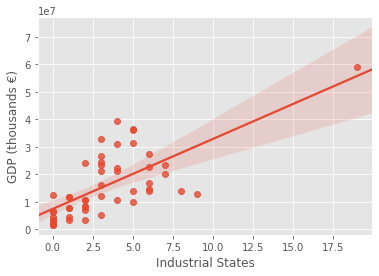

In [135]:
ax = sns.regplot(y='GDP (thousands €)', x='Industrial States', data=spain_data_final[spain_data_final['GDP (thousands €)'] < 1.5e8])

#### 6.3.2 Correlation between GDP and number of power plants

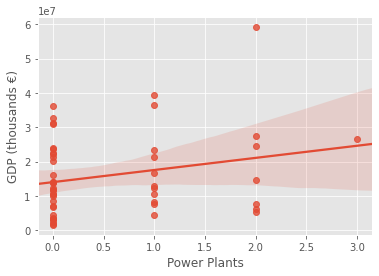

In [136]:
ax = sns.regplot(y='GDP (thousands €)', x='Power Plants', data=spain_data_final[spain_data_final['GDP (thousands €)'] < 1.5e8])

#### 6.3.3 Correlation between GDP per capita and the area of the province

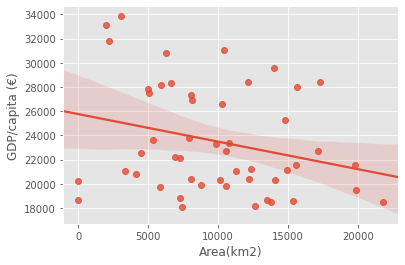

In [137]:
ax = sns.regplot(y='GDP/capita (€)', x='Area(km2)', data=spain_data_final[spain_data_final['GDP (thousands €)'] < 1.5e8])

#### 6.3.4 Correlation between GDP and population

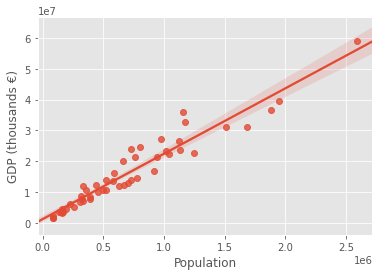

In [138]:
ax = sns.regplot(y='GDP (thousands €)', x='Population', data=spain_data_final[spain_data_final['GDP (thousands €)'] < 1.5e8])

## 7 - Clustering

### 7.1 - Prepare data for clustering (feature selection and data normalization)

In [139]:
spain_data_clustering = spain_data_final[['Province','GDP/capita (€)','GDP (thousands €)','Population','Area(km2)','Industrial States','Power Plants']]
#,

In [140]:
spain_data_clustering = spain_data_clustering.set_index(spain_data_final['Province'])

In [141]:
spain_data_clustering = spain_data_clustering.drop(['Province'], axis = 1)
spain_data_clustering = StandardScaler().fit_transform(spain_data_clustering)
spain_data_clustering[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 2.54600625,  5.48667521,  4.90833833, -0.33675352,  2.03997095,
         1.65703431],
       [ 1.49246335,  3.90967594,  4.04135904, -0.39501118,  3.79126677,
         1.65703431],
       [-0.11649141,  0.94926907,  1.40523213,  0.21411825,  3.79126677,
         1.65703431],
       [-0.76334045,  0.43257015,  0.86851242,  0.85396175,  0.03849002,
         0.46028731],
       [-0.88150867,  0.35306627,  0.80968334, -0.77467676,  0.28867513,
         0.46028731]])

### 7.2 Create and fit kmeans model

In [142]:
nclusters = 4
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(spain_data_clustering)

### 7.3 Insert labels into dataframe.

In [143]:
spain_data_clusters = spain_data_final.copy()
spain_data_clusters.insert(0, 'Cluster Labels', kmeans.labels_)

#### This change in the number of labels is used to make clearer the following map by putting the clusters in a most understandable order.

In [144]:
spain_data_clusters['Cluster Labels'] = spain_data_clusters['Cluster Labels'].replace(3,4).replace(1,3).replace(2,1).replace(0,2)

In [145]:
spain_data_clusters.head()

,Cluster Labels,Province,Autonomous community,GDP (thousands €),GDP/capita (€),Population,Area(km2),Industrial States,Power Plants,Latitude,Longitude,Equivalent radius
0,4,Madrid,Madrid,231133592.0,35913.0,6779888.0,8027.0,12,2,40.416705,-3.703582,50.547734
1,4,Barcelona,Cataluña,171350447.0,30947.0,5743402.0,7733.0,19,2,41.382894,2.177432,49.613409
2,4,Valencia,Comunidad Valenciana,59123107.0,23363.0,2591875.0,10807.0,19,2,39.469707,-0.376335,58.651300
3,2,Sevilla,Andalucía,39535345.0,20314.0,1950219.0,14036.0,4,1,37.388630,-5.995340,66.841586
4,1,Alicante,Comunidad Valenciana,36521398.0,19757.0,1879888.0,5817.0,5,1,38.353738,-0.490185,43.030322


### 7.4 Choropleth map displaying clusters

The following function was extracted from Stack Overflow in order to add categorical labels to choropleth maps.
For more information check the following [link](https://stackoverflow.com/questions/65042654/how-to-add-categorical-legend-to-python-folium-map)

In [ ]:
def add_categorical_legend(folium_map, title, colors, labels):
    if len(colors) != len(labels):
        raise ValueError("colors and labels must have the same length.")

    color_by_label = dict(zip(labels, colors))
    
    legend_categories = ""     
    for label, color in color_by_label.items():
        legend_categories += f"<li><span style='background:{color}'></span>{label}</li>"
        
    legend_html = f"""
    <div id='maplegend' class='maplegend'>
      <div class='legend-title'>{title}</div>
      <div class='legend-scale'>
        <ul class='legend-labels'>
        {legend_categories}
        </ul>
      </div>
    </div>
    """
    script = f"""
        <script type="text/javascript">
        var oneTimeExecution = (function() {{
                    var executed = false;
                    return function() {{
                        if (!executed) {{
                             var checkExist = setInterval(function() {{
                                       if ((document.getElementsByClassName('leaflet-top leaflet-right').length) || (!executed)) {{
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.display = "flex"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.flexDirection = "column"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].innerHTML += `{legend_html}`;
                                          clearInterval(checkExist);
                                          executed = true;
                                       }}
                                    }}, 100);
                        }}
                    }};
                }})();
        oneTimeExecution()
        </script>
      """
   

    css = """

    <style type='text/css'>
      .maplegend {
        z-index:9999;
        float:right;
        background-color: rgba(255, 255, 255, 1);
        border-radius: 5px;
        border: 2px solid #bbb;
        padding: 10px;
        font-size:12px;
        positon: relative;
      }
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 0px solid #ccc;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    """

    folium_map.get_root().header.add_child(folium.Element(script + css))

    return folium_map

In [ ]:
choromap_ = folium.Map(location=[latitude, longitude], zoom_start=6)
#Crear el listado de regiones de Italia
communities_geo = r'spain_provinces.geojson'
#Representar el mapa choropleth con número de casos por provincia
choromap_.choropleth(
    geo_data=communities_geo,
    data=spain_data_clusters,
    columns=['Province', 'Cluster Labels'],
    key_on='feature.properties.name',
    fill_color='BuPu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='Cluster Label',
    smooth_factor=0)
for key in choromap_._children:
    if key.startswith('color_map'):
        del(choromap_._children[key])
choromap_ = add_categorical_legend(choromap_, 'Cluster labels',
                             colors = ['#adcbff','#7786ed','#975fc7','#6e0078'],
                           labels = ['1', '2','3','4'])
#Visualizar el mapa
choromap_

### 7.5 Clustering features sorted by cluster

In this section every feature used in the previous clustering is displayed sorted by cluster, in addition to box plots, some scatter plots are used to show a most detailed distribution of the data (in order to make clear overlaped point alpha parameter is fixed at different values depending on the feature to display).

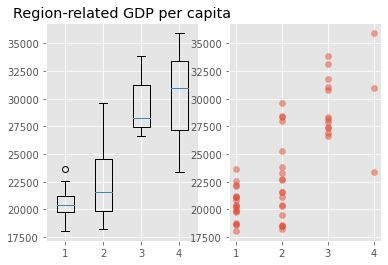

In [146]:
GDP_capita_cluster_1 = spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 1,'GDP/capita (€)'].values
GDP_capita_cluster_2= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 2,'GDP/capita (€)'].values
GDP_capita_cluster_3= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 3,'GDP/capita (€)'].values
GDP_capita_cluster_4= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 4,'GDP/capita (€)'].values
GDP_capita_cluster = [GDP_capita_cluster_1, GDP_capita_cluster_2, GDP_capita_cluster_3, GDP_capita_cluster_4]
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (5,5)
ax[0].set_title('Region-related GDP per capita')
ax[0].boxplot(GDP_capita_cluster)
ax[1].scatter(x = spain_data_clusters['Cluster Labels'], y = spain_data_clusters['GDP/capita (€)'], alpha = 0.5)
plt.show()

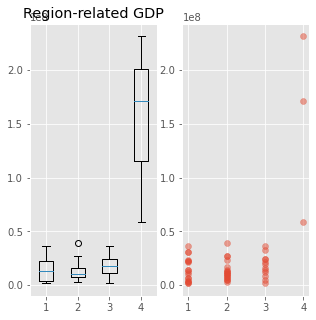

In [147]:
GDP_cluster_1 = spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 1,'GDP (thousands €)'].values
GDP_cluster_2= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 2,'GDP (thousands €)'].values
GDP_cluster_3= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 3,'GDP (thousands €)'].values
GDP_cluster_4= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 4,'GDP (thousands €)'].values
GDP_cluster = [GDP_cluster_1, GDP_cluster_2, GDP_cluster_3, GDP_cluster_4]
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (10,5)
ax[0].set_title('Region-related GDP')
ax[0].boxplot(GDP_cluster)
ax[1].scatter(x = spain_data_clusters['Cluster Labels'], y = spain_data_clusters['GDP (thousands €)'], alpha = 0.5)
plt.show()

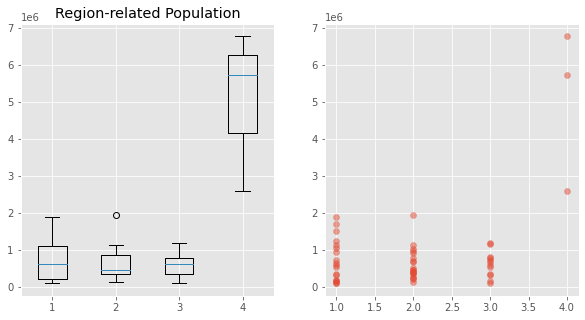

In [148]:
pop_cluster_1 = spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 1,'Population'].values
pop_cluster_2= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 2,'Population'].values
pop_cluster_3= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 3,'Population'].values
pop_cluster_4= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 4,'Population'].values
pop_cluster = [pop_cluster_1, pop_cluster_2, pop_cluster_3, pop_cluster_4]
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (10,5)
ax[0].set_title('Region-related Population')
ax[0].boxplot(pop_cluster)
ax[1].scatter(x = spain_data_clusters['Cluster Labels'], y = spain_data_clusters['Population'], alpha = 0.5)
plt.show()

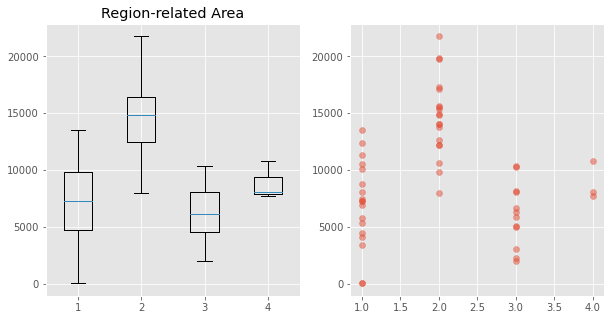

In [149]:
Area_cluster_1 = spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 1,'Area(km2)'].values
Area_cluster_2= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 2,'Area(km2)'].values
Area_cluster_3= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 3,'Area(km2)'].values
Area_cluster_4= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 4,'Area(km2)'].values
Area_cluster = [Area_cluster_1, Area_cluster_2, Area_cluster_3, Area_cluster_4]
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (10,5)
ax[0].set_title('Region-related Area')
ax[0].boxplot(Area_cluster)
ax[1].scatter(x = spain_data_clusters['Cluster Labels'], y = spain_data_clusters['Area(km2)'], alpha = 0.5)
plt.show()

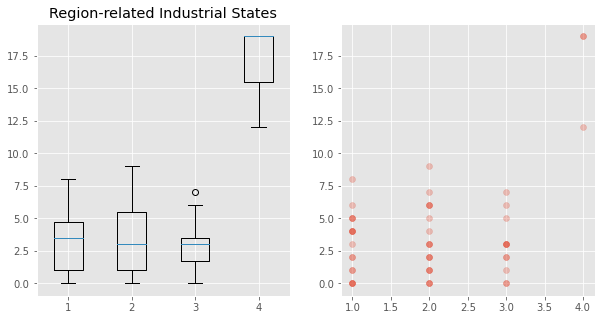

In [150]:
is_cluster_1 = spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 1,'Industrial States'].values
is_cluster_2= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 2,'Industrial States'].values
is_cluster_3= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 3,'Industrial States'].values
is_cluster_4= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 4,'Industrial States'].values
is_cluster = [is_cluster_1, is_cluster_2, is_cluster_3, is_cluster_4]
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (10,5)
ax[0].set_title('Region-related Industrial States')
ax[0].boxplot(is_cluster)
ax[1].scatter(x = spain_data_clusters['Cluster Labels'], y = spain_data_clusters['Industrial States'], alpha = 0.3)
plt.show()

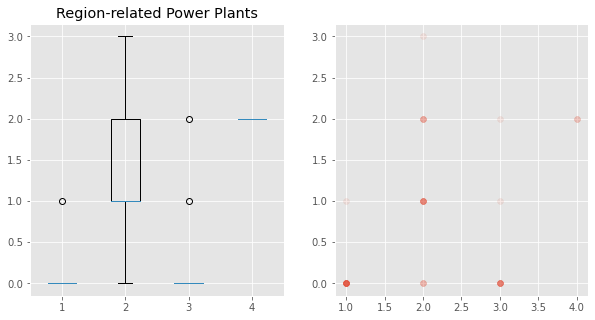

In [151]:
pp_cluster_1 = spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 1,'Power Plants'].values
pp_cluster_2= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 2,'Power Plants'].values
pp_cluster_3= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 3,'Power Plants'].values
pp_cluster_4= spain_data_clusters.loc[spain_data_clusters['Cluster Labels'] == 4,'Power Plants'].values
pp_cluster = [pp_cluster_1, pp_cluster_2, pp_cluster_3, pp_cluster_4]
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (10,5)
ax[0].set_title('Region-related Power Plants')
ax[0].boxplot(pp_cluster)
ax[1].scatter(x = spain_data_clusters['Cluster Labels'], y = spain_data_clusters['Power Plants'], alpha = 0.1)
plt.show()